In [7]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
sys.path.append('/data/jlai/iris-hep-log/code/')
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [19]:
tree.keys()

['event_nr',
 'track_nr',
 'nStates',
 'nMeasurements',
 'nOutliers',
 'nHoles',
 'nSharedHits',
 'chi2Sum',
 'NDF',
 'measurementChi2',
 'outlierChi2',
 'measurementVolume',
 'measurementLayer',
 'outlierVolume',
 'outlierLayer',
 'nMajorityHits',
 'majorityParticleId',
 'trackClassification',
 't_charge',
 't_time',
 't_vx',
 't_vy',
 't_vz',
 't_px',
 't_py',
 't_pz',
 't_theta',
 't_phi',
 't_eta',
 't_p',
 't_pT',
 't_d0',
 't_z0',
 't_prodR',
 'hasFittedParams',
 'eLOC0_fit',
 'eLOC1_fit',
 'ePHI_fit',
 'eTHETA_fit',
 'eQOP_fit',
 'eT_fit',
 'epT_fit',
 'err_eLOC0_fit',
 'err_eLOC1_fit',
 'err_ePHI_fit',
 'err_eTHETA_fit',
 'err_eQOP_fit',
 'err_eT_fit',
 'res_eLOC0_fit',
 'res_eLOC1_fit',
 'res_ePHI_fit',
 'res_eTHETA_fit',
 'res_eQOP_fit',
 'res_eT_fit',
 'res_ePT_fit',
 'pull_eLOC0_fit',
 'pull_eLOC1_fit',
 'pull_ePHI_fit',
 'pull_eTHETA_fit',
 'pull_eQOP_fit',
 'pull_eT_fit',
 'cov_eLOC0_eLOC0',
 'cov_eLOC0_eLOC1',
 'cov_eLOC0_ePHI',
 'cov_eLOC0_eTHETA',
 'cov_eLOC0_eQOP',
 '

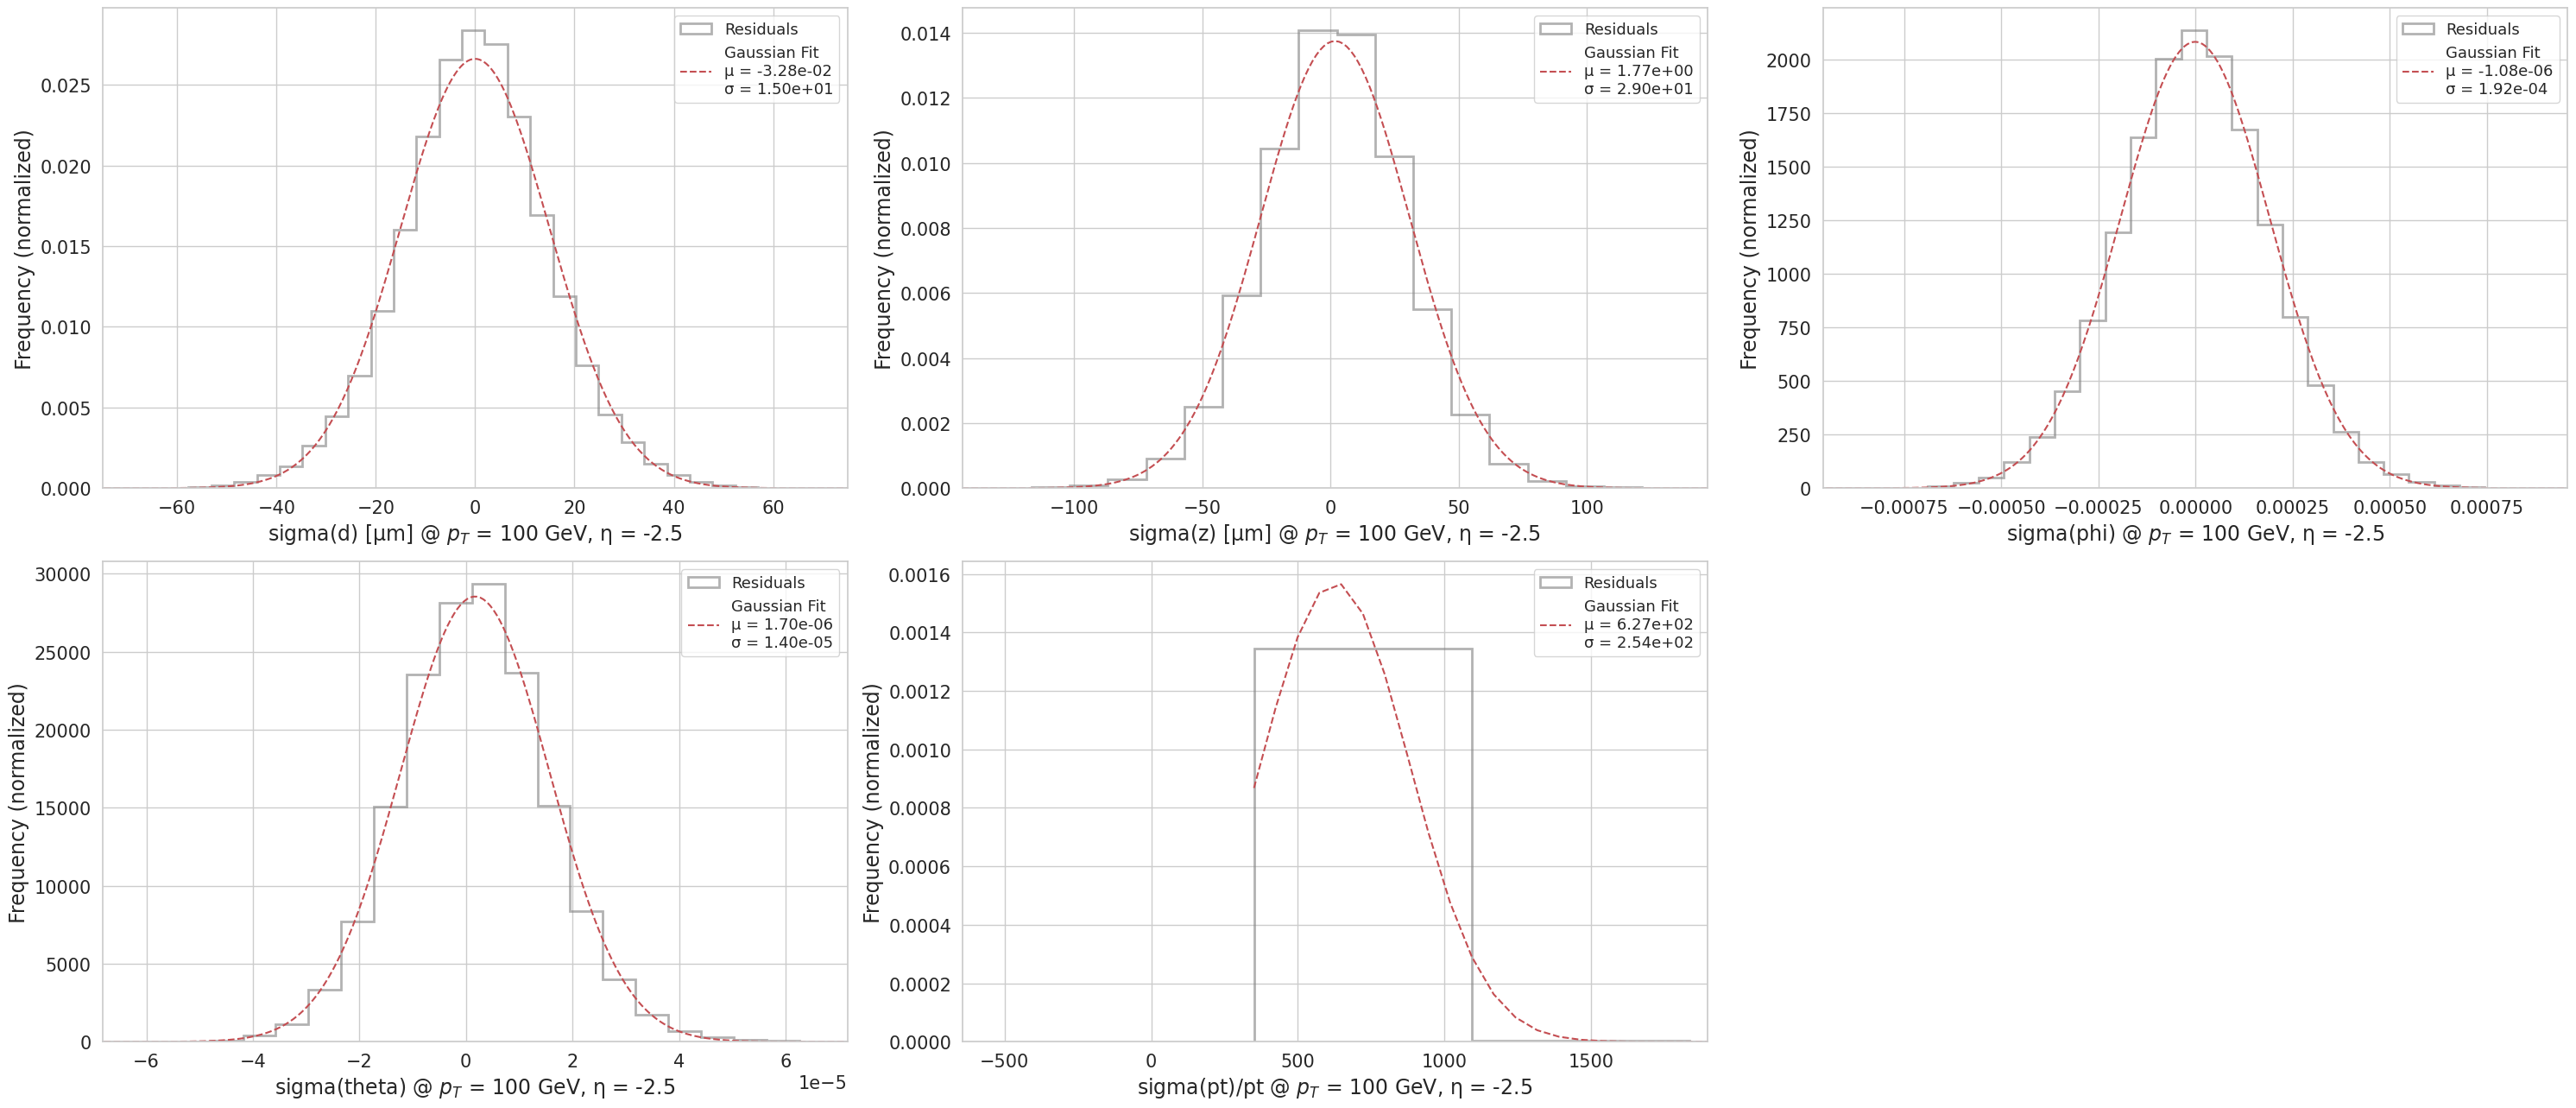

In [47]:

path = f'/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/'
eta_values = np.arange(-2.5, 2.5, 0.5)
i = 0
file = uproot.open(path + f'output_eta_{eta_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_ePT_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])
p = np.abs( 1 / arrays['eQOP_fit'] )

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    # 'sigma(pt)/pt': ak.flatten(arrays['res_ePT_fit']/pT_reco),
    'sigma(pt)/pt': ak.flatten(p)
}

p, eta = PT_VALUE, eta_values[i]
B, m = 2, 0.106
fit_results = {}

# Decide the order explicitly so plots are stable
keys_order = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
title_labels = ['sigma(d) [μm]', 'sigma(z) [μm]', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

plt.figure(figsize=(30, 13))

for i, key in enumerate(keys_order):
    data = ak.to_numpy(labels[key])
    data = data[~np.isnan(data)]

    if data.size == 0:
        fit_results[key] = np.nan
        continue

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma

    plt.subplot(2, 3, i + 1)
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2,
                               density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma),
             'r--', label=f'Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.xlabel(f"{title_labels[i]} @ $p_T$ = {p} GeV, η = {eta}")
    plt.xlim(mu - 5*sigma, mu + 5*sigma)
    plt.xticks()
    # plt.xlabel(key)
    plt.ylabel("Frequency (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
# plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
# p, eta = pT_values[i], 0
# B, m = 2, 0.106
# path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
# mydetector = inputfromfile(path+'ODD.txt', 0)
# calc_result = mydetector.errorcalculation(p, B, eta, m)

# # < -- plot comparsion -- >
# var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

# plt.figure(figsize=(20, 10))
# for var_label in var_labels:
#     idx = var_labels.index(var_label)
#     plt.subplot(231 + idx)

#     key = var_label
#     y_calc = calc_result[var_label]
#     y_acts = fit_results[key]

#     plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
#     plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
#     plt.xlabel(r"$p_T$ [GeV]")
#     plt.ylabel(var_label)
#     plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
#     plt.legend()
#     plt.grid(True)

# plt.tight_layout()
plt.show()

In [48]:
pixel_thickness = 0.012278      
sstrip_thickness = 0.018912      
lstrip_thickness = 0.030750      

In [35]:
PT_VALUE = 100
path = f'/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

eta_values = np.arange(-2.5, 2.5, 0.5)
for eta_value in eta_values:
    print(f'Saving ACTS track resol with η = {eta_value}')
    file = uproot.open(path + f'output_eta_{eta_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth)/pT_reco)
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)

        y_acts[key].append(sigma)
        # y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)
        y_acts_err[key].append(sigma / np.sqrt(2*max(N-1,1)) if N > 1 else 0.0)

Saving ACTS track resol with η = -2.5
Saving ACTS track resol with η = -2.0
Saving ACTS track resol with η = -1.5
Saving ACTS track resol with η = -1.0
Saving ACTS track resol with η = -0.5
Saving ACTS track resol with η = 0.0
Saving ACTS track resol with η = 0.5
Saving ACTS track resol with η = 1.0
Saving ACTS track resol with η = 1.5
Saving ACTS track resol with η = 2.0


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

In [51]:

def build_df_layers(MEAS_PATH):
    # --- Read per-hit quantities ---
    cols = ["volume_id","layer_id","true_x","true_y","true_z","var_loc0","var_loc1"]
    with uproot.open(MEAS_PATH) as f:
        a = f["measurements"].arrays(cols, library="pd")

    # --- Per-hit → per-layer medians + derived geometry ---
    a["R_m"]          = np.sqrt(a.true_x**2 + a.true_y**2) * 1e-3  # m
    a["Z_m"]          = np.abs(a.true_z) * 1e-3                    # m
    a["sigma_loc0_m"] = np.sqrt(a.var_loc0.clip(lower=0)) * 1e-3   # m
    a["sigma_loc1_m"] = np.sqrt(a.var_loc1.clip(lower=0)) * 1e-3   # m

    df_layers = (
        a.groupby(["volume_id","layer_id"], as_index=False)
         .agg(R_m=("R_m","median"),
              Z_m=("Z_m","median"),
              sigma_loc0_m=("sigma_loc0_m","median"),
              sigma_loc1_m=("sigma_loc1_m","median"))
         .sort_values(["volume_id","layer_id"])
         .reset_index(drop=True)
    )

    # --- Map volume → technology ---
    PIXEL  = {16,17,18}      # ODD: 17=barrel, 16/18=endcaps
    SSTRIP = {23,24,25}
    LSTRIP = {28,29,30}

    def vol_to_tech(vid: int) -> str:
        if vid in PIXEL:  return "pixel"
        if vid in SSTRIP: return "sstrip"
        if vid in LSTRIP: return "lstrip"
        return "pixel"  # fallback

    df_layers["tech"] = df_layers["volume_id"].map(vol_to_tech)

    # --- Barrel vs Endcap tag ---
    # Pixels: use known mapping; others: geometry heuristic (|Z| >> R ⇒ endcap)
    def is_endcap_row(row):
        vid = int(row["volume_id"])
        if vid in PIXEL:
            return vid in (16, 18)             # pixel endcaps
        return (row["Z_m"] > 1.2 * row["R_m"]) # heuristic for strips

    df_layers["is_endcap"] = df_layers.apply(is_endcap_row, axis=1)

    return df_layers

MEAS_PATH = f"/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/output_eta_{eta_value}/measurements.root"
df_layers = build_df_layers(MEAS_PATH)


# --- constants: single-layer thickness at η = 0 (units: x/X0) ---
pixel_thickness  = 0.012278
sstrip_thickness = 0.018912
lstrip_thickness = 0.030750

thickness_map = {
    "pixel":  pixel_thickness,
    "sstrip": sstrip_thickness,
    "lstrip": lstrip_thickness,
}

# --- angles for this eta ---
theta = 2*np.arctan(np.exp(-eta_value))
sinth = max(np.sin(theta), 1e-12)
costh = max(abs(np.cos(theta)), 1e-12)
tanth = sinth / costh

# --- per-layer value to SAVE to Detector (no core code changes) ---
# barrel: keep single-layer thickness
# endcap: multiply by tan(theta) so later "/ sinθ" -> effective "/ cosθ"
df_layers["x_over_X0_for_detector"] = df_layers.apply(
    lambda r: thickness_map[r["tech"]] * (tanth if r["is_endcap"] else 1.0),
    axis=1,
)

# --- predicted totals for this eta (to COMPARE with material map) ---
# barrel layers contribute thickness/sinθ; endcap layers contribute thickness/cosθ
df_layers["contrib_for_total"] = df_layers.apply(
    lambda r: thickness_map[r["tech"]] / (costh if r["is_endcap"] else sinth),
    axis=1,
)

pred_by_tech = df_layers.groupby("tech")["contrib_for_total"].sum().to_dict()
map_by_tech  = {"pixel": x0_pixel, "sstrip": x0_sstr, "lstrip": x0_lstr}

# per-tech relative differences
rel_diff_by_tech = {
    k: (pred_by_tech.get(k, 0.0) - map_by_tech.get(k, 0.0)) / max(map_by_tech.get(k, 0.0), 1e-12)
    for k in map_by_tech.keys()
}

# overall totals (optionally include beampipe if you want)
pred_total = sum(pred_by_tech.values())  # + (x0_beam if you include beampipe in map_total)
map_total  = sum(map_by_tech.values())   # + (x0_beam if included above)
rel_diff_total = (pred_total - map_total) / max(map_total, 1e-12)

print(f"eta = {eta_value:+.2f}, sinθ={sinth:.4f}, cosθ={costh:.4f}")
print("Predicted totals (sum thickness/sin or /cos):", pred_by_tech)
print("Map totals at this eta:                    ", map_by_tech)
print("Relative diffs per tech:                   ", {k: f"{v:+.2%}" for k,v in rel_diff_by_tech.items()})
print(f"Overall relative diff: {rel_diff_total:+.2%}")


NameError: name 'x0_pixel' is not defined

In [46]:
0.00227 * np.cosh(eta_values)

array([0.0139203 , 0.00854018, 0.00533997, 0.00350279, 0.00255971,
       0.00227   , 0.00255971, 0.00350279, 0.00533997, 0.00854018])

Beam pipe: x/X0 = 0.01349
Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):
 volume_id  layer_id   tech  x_over_X0  sigma_loc0_m  sigma_loc1_m      R_m
        16         8  pixel   0.040262      0.000015      0.000015 0.170011
        16        10  pixel   0.040262      0.000015      0.000015 0.161037
        16        12  pixel   0.040262      0.000015      0.000015 0.139205
        16        14  pixel   0.040262      0.000015      0.000015 0.118112
        16        16  pixel   0.040262      0.000015      0.000015 0.104668
        17         2  pixel   0.040262      0.000015      0.000015 0.032213
        17         4  pixel   0.040262      0.000015      0.000015 0.068188
        17         6  pixel   0.040262      0.000015      0.000015 0.114005
        23         2 sstrip   0.017843      0.000043      0.001200 0.488351
        23         4 sstrip   0.017843      0.000043      0.001200 0.422209
        23         6 sstrip   0.017843      0.000043      0.001200 0.362756

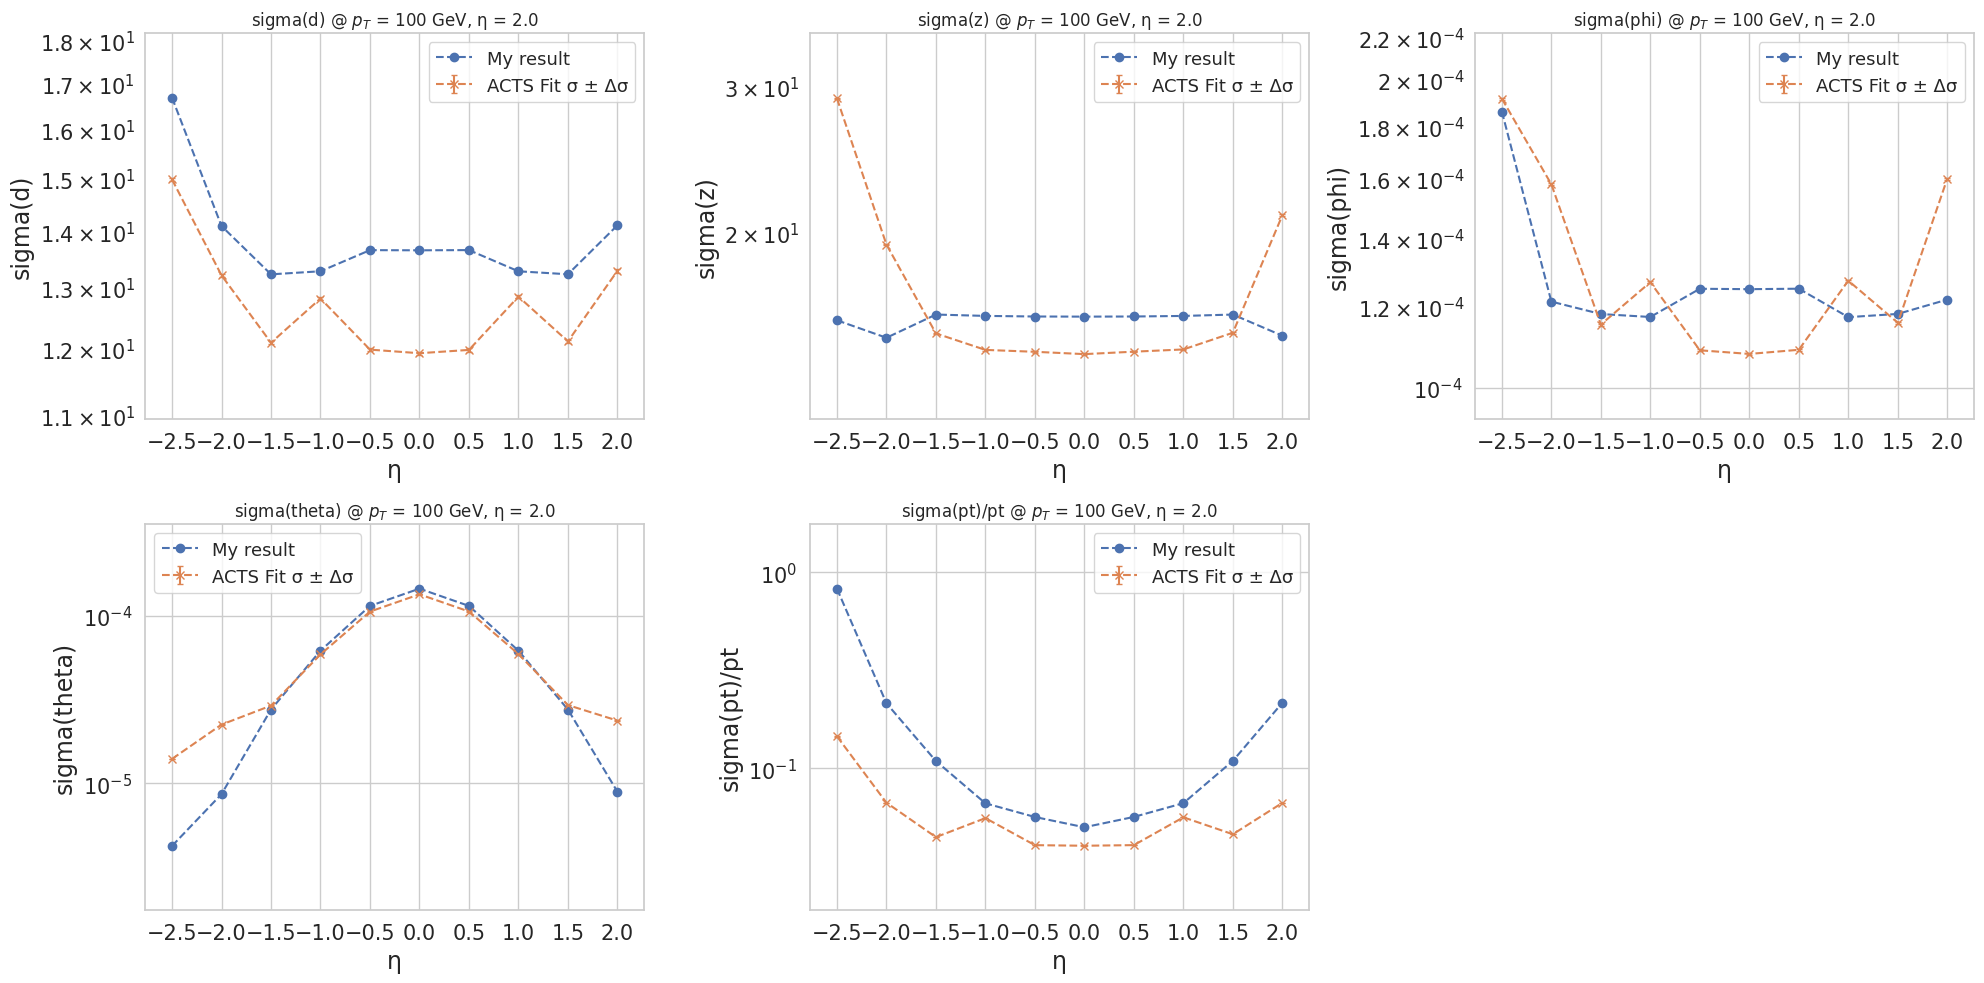

In [37]:
def D(pT_value, eta_value):    
    MEAS_PATH = f"/data/jlai/iris-hep/OutputETA_pt_{PT_VALUE}/output_eta_{eta_value}/measurements.root"
    MAT_PATH  = "/data/jlai/iris-hep/material_composition.root"

    PIXEL   = {16, 17, 18}   # 17 barrel, 16/18 endcaps
    SSTRIP  = {23, 24, 25}
    LSTRIP  = {28, 29, 30}

    def vol_to_tech(vid: int) -> str:
        if vid in PIXEL:  return "pixel"
        if vid in SSTRIP: return "sstrip"
        if vid in LSTRIP: return "lstrip"
        return "pixel"  # fallback

    # ---------- 1) per-layer medians from measurements ----------
    cols = ["volume_id","layer_id","true_x","true_y","true_z","var_loc0","var_loc1"]
    with uproot.open(MEAS_PATH) as f:
        a = f["measurements"].arrays(cols, library="pd")

    a["R_m"]           = np.sqrt(a.true_x**2 + a.true_y**2) * 1e-3
    a["sigma_loc0_m"]  = np.sqrt(a.var_loc0.clip(lower=0)) * 1e-3
    a["sigma_loc1_m"]  = np.sqrt(a.var_loc1.clip(lower=0)) * 1e-3

    df_layers = (
        a.groupby(["volume_id","layer_id"], as_index=False)
        .agg(R_m=("R_m","median"),
            sigma_loc0_m=("sigma_loc0_m","median"),
            sigma_loc1_m=("sigma_loc1_m","median"))
        .sort_values(["volume_id","layer_id"])
        .reset_index(drop=True)
    )

    # ---------- 2) x/X0 per technology at η≈0 ----------
    with uproot.open(MAT_PATH) as mf:
        def x0_at_eta0(key):
            h = mf[key]
            edges = h.axis().edges() if hasattr(h, "axis") else np.linspace(-5,5,len(h.values())+1)
            vals  = h.values()
            i = int(np.clip(np.digitize([eta_value], edges)[0] - 1, 0, len(vals)-1))
            return float(vals[i])
        x0_beam  = x0_at_eta0("beampipe_x0_vs_eta_all")
        x0_pixel = x0_at_eta0("pixel_x0_vs_eta_all")
        x0_sstr  = x0_at_eta0("sstrips_x0_vs_eta_all")
        x0_lstr  = x0_at_eta0("lstrips_x0_vs_eta_all")

    def x0_for_tech(tech: str) -> float:
        return {"pixel": x0_pixel, "sstrip": x0_sstr, "lstrip": x0_lstr}.get(tech, x0_pixel)

    df_layers["tech"]       = df_layers["volume_id"].map(vol_to_tech)
        
    x0_map = {
        "pixel":  x0_pixel,
        "sstrip": x0_sstr,
        "lstrip": x0_lstr,
    }
    df_layers["x0_total_by_tech"] = df_layers["tech"].map(x0_map)

    # How many layers of each tech are present in *this* measurements file?
    n_layers_by_tech = df_layers.groupby("tech").size().to_dict()

    # Per-layer share: total / count
    df_layers["x_over_X0"] = df_layers.apply(
        lambda r: r["x0_total_by_tech"] / max(n_layers_by_tech.get(r["tech"], 1), 1),
        axis=1,
    )

    # df_layers["x_over_X0"]  = df_layers["tech"].map(x0_for_tech)

    # ---------- 3) enforce 9999 for missing sigma_loc1 ----------
    df_layers["sigma_loc1_for_add"] = df_layers["sigma_loc1_m"].fillna(9999.0)

    # ---------- 4) build Detector ----------
    mydetector = Detector()

    mydetector.addlayer(x0_beam, 9999.0, 9999.0, 0.024)
    print(f"Beam pipe: x/X0 = {x0_beam:.4g}")

    for _, row in df_layers.sort_values("R_m").iterrows():
        mydetector.addlayer(
            float(row["x_over_X0"]),
            float(row["sigma_loc0_m"]),
            float(row["sigma_loc1_for_add"]),  # <- NaNs become 9999 here
            float(row["R_m"]),
        )

    # ---------- 5) nice print (show 9999 in the table too) ----------
    out = df_layers.copy()
    out["sigma_loc1_m"] = out["sigma_loc1_m"].fillna(9999.0)
    print("Layers added (x/X0, sigma_xy [m], sigma_z [m or 9999], R [m]):")
    print(out[["volume_id","layer_id","tech","x_over_X0","sigma_loc0_m","sigma_loc1_m","R_m"]]
          .to_string(index=False))
    return mydetector


# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for eta_value in eta_values:
        # p, eta = PT_VALUE * np.cosh(eta_value), 0
        p, eta = PT_VALUE, eta_value
        B, m = 2.0, 0.105658
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

# < -- Tracking Error Calculator -- >
def cal2():
    y_calc = {label: [] for label in var_labels}

    for eta_value in eta_values:
        p, eta = PT_VALUE * np.cosh(eta_value), eta_value
        # p, eta = PT_VALUE, eta_value
        B, m = 2.0, 0.105658
        mydetector = D(PT_VALUE, eta)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc_default = cal(path+'ODD.txt')
y_calc_result = cal2()

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    # plt.plot(eta_values, y_calc_default[var_label], 'o--', label=f"Default Calculator in zenodo")
    plt.plot(eta_values, y_calc_result[var_label], 'o--', label=f"My result")

    plt.errorbar(eta_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"η")
    plt.xticks(eta_values)
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {PT_VALUE} GeV, η = {eta_value}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.margins(x=0.06, y=0.25)  # increase y if you want even more headroom

plt.tight_layout()
plt.show()